# Assignement Module 2

## Sofia Davoli
### 813479


In [2]:
#import libraries

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime as dtm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pickle
import scipy
from scipy import stats
import matplotlib.dates as mdates

## Load data files

Previously created reading 9950 stations files:

13  stations with no data (not acquired)

1942  stations with too little data (not acquired)

681  stations with not enough data for the ref. period (not acquired)

7314 valid stations acquired

In [3]:
metadata0= pd.read_pickle("metadata0.pkl")
# Take station IDs as index for metadata0
metadata0 = metadata0.set_index(['ID'])

data0 = pd.read_pickle("data0.pkl")

In [4]:
metadata0.shape

(7314, 5)

In [5]:
data0.shape

(2028, 7314)

## Preprocessing

In [6]:
# Convert all missing values (-99.0) into NAN
data0[data0 == -99.0] = np.nan

In [7]:
# Fix longitudes
metadata0.lon = -metadata0.lon

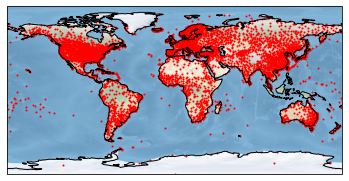

In [8]:
# Plot stations of dataset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.scatter([metadata0.lon],[metadata0.lat],color='r',marker='o',s=1.0)
plt.show()

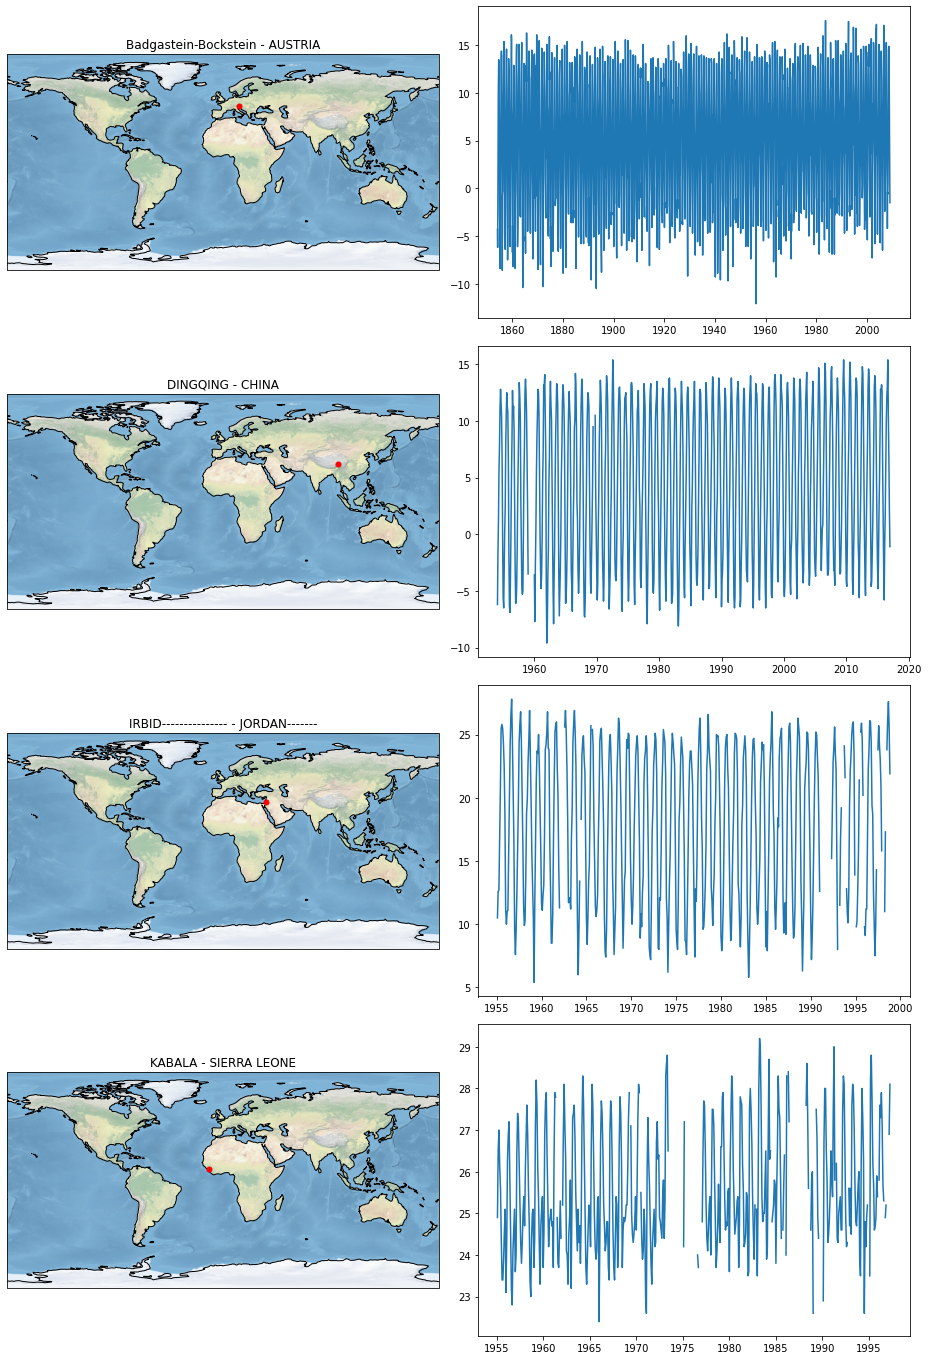

In [9]:
#-- Plot time series from a few randomly chosen stations --

#- Set multipanel plot
fig = plt.figure(figsize=(13,19))

no = 4   # number of randomn stations to pick

subplots = (no,2)
n_panels = subplots[0] * subplots[1]

proj = ccrs.PlateCarree()

#- Select sites
rssite = np.random.randint(len(data0.columns), size=no)
ssite = metadata0.index[rssite]

for fi, f in enumerate(ssite):

    #- locate on map
    ax = fig.add_subplot(subplots[0], subplots[1], (fi*2)+1, projection=proj)
    ax.set_title(' - '.join([metadata0.stname[ssite[fi]],metadata0.country[ssite[fi]]]))
    ax.stock_img()
    ax.coastlines()
    plt.plot(metadata0.lon[ssite[fi]], metadata0.lat[ssite[fi]],
         color='red', marker='o', markersize=5,
         transform=ccrs.Geodetic())         
 
    #- time series
    tser = fig.add_subplot(subplots[0], subplots[1], (fi+1)*2)
    #data0[ssite[fi]].plot()  
    plt.plot(data0[ssite[fi]])

fig.tight_layout()
plt.show()

## (1) Deal with the time series, in particular what to do about missing data 


In [10]:

# retain only station with more than 30% of data
print(data0.shape)
thresh=data0.shape[0]*30/100
thresh=int(thresh)
print(thresh)
data_missing=data0.dropna(axis=1,thresh=thresh)  #drop stations with more than 608 missing values

(2028, 7314)
608


In [11]:
#remove station in metadata0 dataset

station_na=[]
for col in data_missing.columns: 
    station_na.append(col) 

d_col=[]
for col in data0.columns:
    d_col.append(col)

to_remove=list(set(d_col) - set(station_na))

met1=metadata0
met1
print('removing '+ str(len(to_remove))+' stations with less than 30% of data') #removing 1442 stations

for el in to_remove:
    met1=met1.drop(index=el)
    
    

removing 1442 stations with less than 30% of data


## After preprocessing we can check which stations were removed.
## In this case, the 30% missing theshold removed stations of Africa and South America

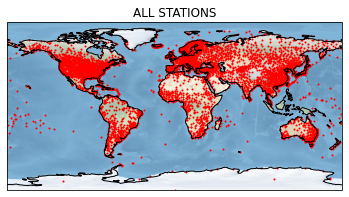

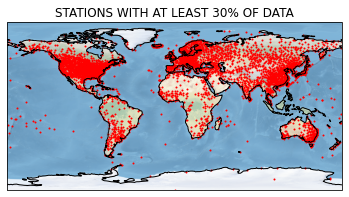

In [12]:
#Plot to see differencces of stations

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.scatter([metadata0.lon],[metadata0.lat],color='r',marker='o',s=1.0)
plt.title('ALL STATIONS')
plt.show()
# Plot stations in our dataset

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.scatter([met1.lon],[met1.lat],color='r',marker='o',s=1.0)
plt.title('STATIONS WITH AT LEAST 30% OF DATA')
plt.show()

## (2) Transform all TEMPERATURE time series to TEMPERATURE ANOMALY time series, with respect to a reference period

In [13]:
# ANOMALY(m) = DATA(m) - AVERAGE[ref. period](m) , for each month (m=1..12)
# First, let's identify the position along the time index that corresponds to the begining/end of the reference period

x1=data_missing.index.get_loc('1961-01-31')
x2=data_missing.index.get_loc('1990-12-31')

# Then calculate the "Normals"
data_normals = data_missing[x1:x2].groupby(data_missing[x1:x2].index.month).mean()


In [14]:
# Finally, let's subtract normals from the the original time series, to get 
# the time series of the temperature anomalies for each station 
# (Note that this operation would be efficiently done with 2D data organization, such as in the original text files)


taxis = pd.date_range('1850-01', '2019-01', freq='M')
nmonths=len(taxis)
nyears=nmonths/12

# Make a copy of data0 (data_anom) to store the anomalies
data_anom = data_missing

# Then loop through all the years (January) in the time axis, and substract the Normals from each chunk of 12 months

y0=0
from tqdm import tqdm
for yi in tqdm(range(0,int(nyears))):
  data_anom.iloc[y0:y0+12,:] = data_missing.iloc[y0:y0+12,:]-np.array(data_normals.iloc[:,:])
  y0+=12

  0%|          | 0/169 [00:00<?, ?it/s]C:\Users\davol\anaconda3\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\davol\anaconda3\envs\geo_env\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
100%|██████████| 169/169 [00:00<00:00, 898.72it/s]


In [15]:
data_anom.to_pickle("data_anom.pkl")

## (3)  Create a grid to get the average time series of all stations in grid cell at monthy resolution and than integrate to annual resolution  

In [16]:
# create grid 

resol = 15   # degrees (E and N)   #risoluzone di 15 gradi
nlon = np.int(360/resol)
nlat = np.int(180/resol)

# define grid cell margins

grlons = np.empty([nlon+1],dtype='float') 
grlats = np.empty([nlat+1],dtype='float') 
grlons[0] = -180.
grlats[0] = -90.
for i in range(1,nlon+1):
  grlons[i]=grlons[i-1]+resol
for i in range(1,nlat+1):
  grlats[i]=grlats[i-1]+resol

<ipython-input-16-3f0ddc2770c7>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nlon = np.int(360/resol)
<ipython-input-16-3f0ddc2770c7>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more detail

In [17]:
# Create data structure to host the gridded dataset:
# what will it be ?  -> I chose 3D numpy array

data_mo = np.empty([nmonths,nlat,nlon],dtype=float)
data_mo[:,:,:] = np.nan

data_yr = np.empty([int(nyears),nlat,nlon],dtype=float)
data_yr[:,:,:] = np.nan

In [18]:
# Iterate over grid cells and 
# - get the average time series of all stations in grid cell at monthy resolution
# - integrate to annual resolution  

for j in range(0,nlat):
  for i in range(0,nlon):
    
    dummy = met1[met1.lon >= grlons[i]]
    dummy = dummy[dummy.lon < grlons[i+1]]
    dummy = dummy[dummy.lat >= grlats[j]]
    dummy = dummy[dummy.lat < grlats[j+1]]

    #print('*',grlons[i],grlons[i+1],grlats[j],grlats[j+1])
    #print(dummy.index)

    if (len(dummy.index) > 0):
 
      # calculation

      data_mo[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1)).flatten()
        
      data_yr[:,j,i] = np.array(data_anom[dummy.index].mean(axis=1).resample("Y").mean()).flatten()

      

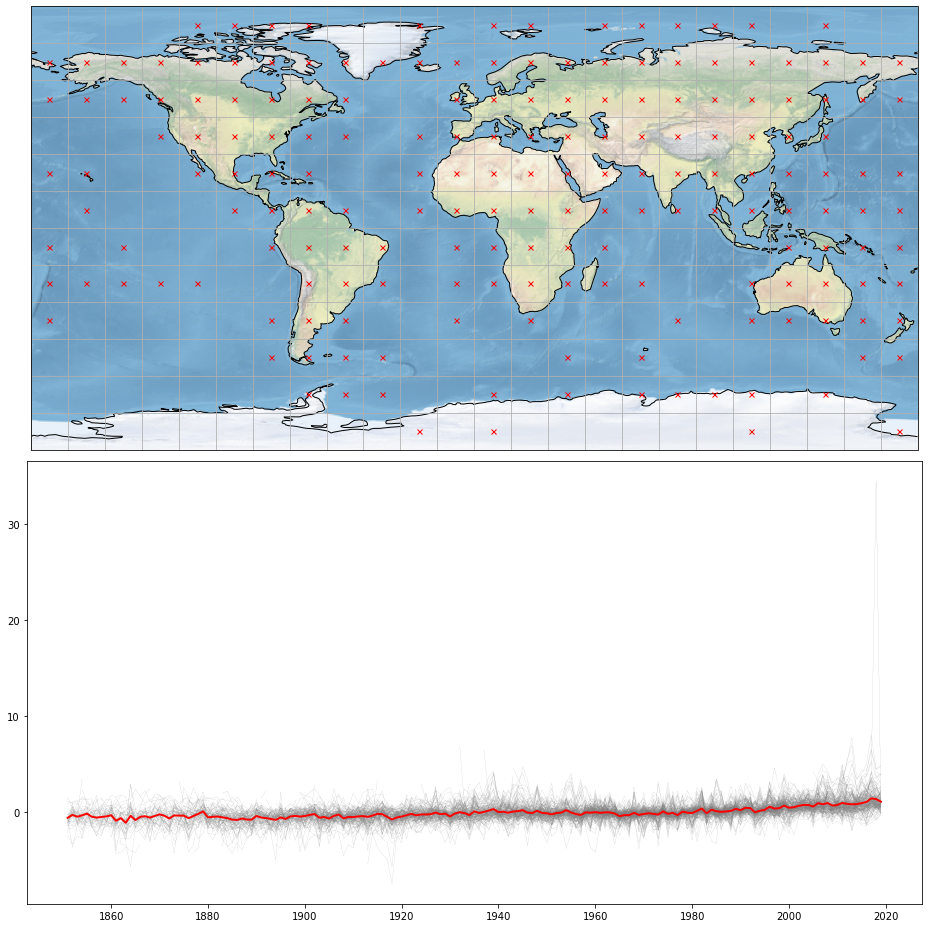

In [17]:
# Prepare to display to check things  

fig = plt.figure(figsize=(13,13))  
subplots = (2,1)

ax = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))

tser = fig.add_subplot(subplots[0], subplots[1], 2)

# Initialize data structure to host global average temperature anomaly time series

data_glob = np.empty([int(nyears)],dtype=float)
data_glob[:] = np.nan

# loop over all grid cells

for j in range(0,nlat):
  for i in range(0,nlon):
    
    # Check if current grid cell has an associated time series
    
    if not(np.isnan(data_yr[:,j,i]).all()):
     
      #  place a marker on the map, and plot individual grid cell time series 

      ax.plot( grlons[i:i+2].sum()/2, grlats[j:j+2].sum()/2,
         color='red', marker='x', markersize=5,transform=ccrs.PlateCarree())     
      plt.plot(pd.date_range('1850-01', '2019-01', freq='Y'),data_yr[:,j,i],color='gray',linewidth=0.1) 

# calculate the global average at each time step      
        
for t in range(0,int(nyears)):  

    local = data_yr[t,:,:]
    valid = np.isnan(data_yr[t,:,:])
    data_glob[t] = np.nanmean(local[~valid])

# plot the global average curve  
    
plt.plot(pd.date_range('1850-01', '2019-01', freq='Y'),data_glob[:],color='red',linewidth=2) 

fig.tight_layout()  
plt.show() 

## What is the difference in the average the global mean temperature anomaly for the last 30 years of the record, compared to that of the first three decades of the twentieth century ?

In [18]:
first_30_yr=data_anom.loc['1850-01-31':'1880-01-31']
last_30_yr=data_anom.loc['1988-01-31':'2018-12-31']

In [19]:
#average the global mean temperature anomaly
df = last_30_yr.groupby(last_30_yr.index.strftime('%b')).mean()
df2=first_30_yr.groupby(first_30_yr.index.strftime('%b')).mean()
last_30_yr_mean=df.mean(axis=1)
first_30_yr_mean=df2.mean(axis=1)

In [20]:
# adjust data structure
last_30_yr_mean_df = pd.Series.to_frame(last_30_yr_mean)
last_30_yr_mean_df['time'] = list(last_30_yr_mean.index)
last_30_yr_mean_df['time']=pd.to_datetime(last_30_yr_mean_df['time'], format="%b")
last_30_yr_mean_df = last_30_yr_mean_df.set_index(['time'])

first_30_yr_mean_df = pd.Series.to_frame(first_30_yr_mean)
first_30_yr_mean_df['time'] = list(first_30_yr_mean.index)
first_30_yr_mean_df['time']=pd.to_datetime(first_30_yr_mean_df['time'], format="%b")
first_30_yr_mean_df = first_30_yr_mean_df.set_index(['time'])

In [21]:
final=last_30_yr_mean_df.merge(first_30_yr_mean_df, on='time')
final.rename(columns={'0_x':'1988-2018_mean','0_y':'1850-1880_mean' },inplace=True)   
final

,1988-2018_mean,1850-1880_mean
time,,
1900-04-01,0.741384,-0.493183
1900-08-01,0.697355,0.042936
1900-12-01,0.761082,-0.927207
1900-02-01,1.048054,-0.264343
1900-01-01,1.163631,0.020672
1900-07-01,0.630524,0.138287
1900-06-01,0.637476,0.038154
1900-03-01,0.918918,-0.770440
1900-05-01,0.610068,-0.398620


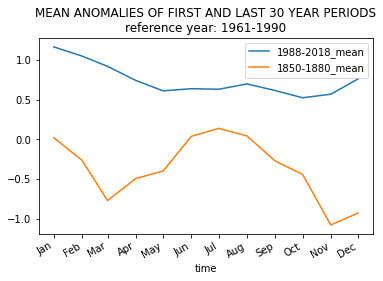

In [22]:
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

final.plot()
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)
plt.title('MEAN ANOMALIES OF FIRST AND LAST 30 YEAR PERIODS\n'+ 'reference year: 1961-1990')
plt.show()

In [23]:
print('1850-1880 annual average = '+ str(first_30_yr_mean.mean()))
print('1988-2018 annual average = '+ str(last_30_yr_mean.mean()))

1850-1880 annual average = -0.3670603512210346
1988-2018 annual average = 0.7428395715008486


# T-test for sifnificance

If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

Here pvalue=1.7565775547200034e-08 so we reject H0 of equal averages.

In [24]:
scipy.stats.ttest_ind(last_30_yr_mean, first_30_yr_mean)


Ttest_indResult(statistic=8.595492443223526, pvalue=1.7565775547200034e-08)